## Objectives of the practical work

The objective is to get hands on experience on the fundamental elements of neural networks:
 
 - perceptron architecture (linear regression)
 - loss function
 - empirical loss
 - gradient descent

For this we will implement from scratch the data-structure and algorithms to train a perceptron. Note that slides related to the perceptron and neural networks in general are available on [moodle](https://moodle.insa-toulouse.fr/course/view.php?id=1822#section-2).

## Dataset

The objective of the regression is the prediction of the hydrodynamic performance of sailing yachts from dimensions and velocity.
The **inputs** are linked to dimension and hydrodynamics characteristics:
1. Longitudinal position of the center of buoyancy
(*flottabilité*), adimensional.
2. Prismatic coefficient, adimensional.
3. Length-displacement ratio, adimensional.
4. Beam -draught ratio ((*tiran d’eau*), adimensional.
5. Length-beam ratio, adimensional.
6. Froude number, adimensional

**Target value/predicted value (Output)** = Residuary resistance per unit weight of
displacement, adimensional

In [27]:
# Import some useful libraries and functions

import numpy as np
import pandas

def print_stats(dataset):
    """Print statistics of a dataset"""
    print(pandas.DataFrame(dataset).describe())


In [28]:
# Download the data set and place in the current folder (works on linux only)
filename = 'yacht_hydrodynamics.data'

import os.path
import requests

if not os.path.exists(filename):
    print("Downloading dataset...")
    r = requests.get('https://arbimo.github.io/tp-supervised-learning/tp2/' + filename)
    open(filename , 'wb').write(r.content)
    
print('Dataset available')

Dataset available


### Explore the dataset

- how many examples are there in the dataset?
- how many features for each example?
- what is the ground truth of the 10th example

- There are 308 exaamples in the  data set
- 6 features for each example and one ground value
- 1.83

In [29]:
# loads the dataset and slip between inputs (X) and ground truth (Y)
dataset = np.genfromtxt("yacht_hydrodynamics.data", delimiter='')
X = dataset[:, :-1] # examples features
Y = dataset[:, -1]  # ground truth

# Print dataset size
print(np.shape(dataset))

# Print ground truth of the tenth example
print(dataset[9,-1])

# Print the first 5 examples
for i in range(0,5):
    print(f"f({X[i]}) = {Y[i]}")

(308, 7)
1.83
f([-5.    0.6   4.78  4.24  3.15  0.35]) = 8.62
f([-5.     0.565  4.77   3.99   3.15   0.15 ]) = 0.18
f([-2.3    0.565  4.78   5.35   2.76   0.15 ]) = 0.29
f([-5.     0.6    4.78   4.24   3.15   0.325]) = 6.2
f([0.    0.53  4.78  3.75  3.15  0.175]) = 0.59


The following command adds a column to the inputs.

- what is in the value added this column?
- why are we doing this?


- only ones are added in this column
- To be able to create bias ??

In [30]:
X = dataset[:, :-1] # examples features
print(np.shape(X))
X = np.insert(X, 0, np.ones((len(X))), axis= 1)
print(np.shape(X))
print_stats(X)


(308, 6)
(308, 7)
           0           1           2           3           4           5  \
count  308.0  308.000000  308.000000  308.000000  308.000000  308.000000   
mean     1.0   -2.381818    0.564136    4.788636    3.936818    3.206818   
std      0.0    1.513219    0.023290    0.253057    0.548193    0.247998   
min      1.0   -5.000000    0.530000    4.340000    2.810000    2.730000   
25%      1.0   -2.400000    0.546000    4.770000    3.750000    3.150000   
50%      1.0   -2.300000    0.565000    4.780000    3.955000    3.150000   
75%      1.0   -2.300000    0.574000    5.100000    4.170000    3.510000   
max      1.0    0.000000    0.600000    5.140000    5.350000    3.640000   

                6  
count  308.000000  
mean     0.287500  
std      0.100942  
min      0.125000  
25%      0.200000  
50%      0.287500  
75%      0.375000  
max      0.450000  


## Creating the perceptron

![Perceptron for regression](https://arbimo.github.io/tp-supervised-learning/tp2/perceptron-regression.png)

We now want to define a perceptron, that is, a function of the form: 

$h_w(x) = w_0 + w_1 \times x_1 + \dots + w_n \times x_n$

- Complete the code snippet below to:
  - create the vector of weight `w`, initialize to arbitrary values (we suggest 0)
  - implement the `h` function that evaluate an example based on the vector of weights
  - check if this works on a few examples

In [31]:
w = np.zeros(np.shape(X)[1],dtype=float)

def h(w, x):
    return np.dot(w,x)

# print the ground truth and the evaluation of h_w on the first example
for i in range(0,5):
    print(f"f({X[i]}) = {Y[i]} and h_w ={h(X[i],w)}")

f([ 1.   -5.    0.6   4.78  4.24  3.15  0.35]) = 8.62 and h_w =0.0
f([ 1.    -5.     0.565  4.77   3.99   3.15   0.15 ]) = 0.18 and h_w =0.0
f([ 1.    -2.3    0.565  4.78   5.35   2.76   0.15 ]) = 0.29 and h_w =0.0
f([ 1.    -5.     0.6    4.78   4.24   3.15   0.325]) = 6.2 and h_w =0.0
f([1.    0.    0.53  4.78  3.75  3.15  0.175]) = 0.59 and h_w =0.0


## Loss function

Complete the definiton of the loss function below such that, for a **single** example `x` with ground truth `y`, it returns the $L_2$ loss of $h_w$ on `x`.

In [32]:
def loss(w, x, y):
    return (y-h(w,x))**2

# for i in range(0,5):
#     print(f"f({X[i]}) = {Y[i]} and h_w ={h(w,X[i])} and diff = {loss(w,X[i],Y[i])}")

## Empirical loss

Complete the function below to compute the empirical loss of $h_w$ on a **set** of examples $X$ with associated ground truths $Y$.

In [33]:
def emp_loss(w, X, Y):
    res = np.zeros_like(Y)
    for index in range(0,np.shape(X)[0]):
        res[index] = loss(w,X[index],Y[index])
    return np.average(res)

## Gradient update

A gradient update is of the form: $w \gets w + dw$

- Complete the function below so that it computes the $dw$ term (the 'update') based on a set of examples `(X, Y)` the step (`alpha`)

If you are not sure about the gradient computation, check out the [perceptron slides](https://moodle.insa-toulouse.fr/pluginfile.php/120391/mod_resource/content/1/cm1.pdf) on [Moodle](https://moodle.insa-toulouse.fr/course/view.php?id=1822) (in particular, slide 25 to 27).

In [34]:
def compute_update(w, X, Y, alpha):
    dw = np.zeros_like(w)
    dif = 0
    for i in range(0,np.size(w)):
        res = 0
        for index,line in enumerate(X):
            if (i!=0):
                res += (Y[index] - h(w,line)) * line[i]
            else:
                res += Y[index] - h(w,line)
        dw[i] = res * alpha
    return dw
    

        
compute_update(w, X, Y, alpha = 10e-7)

array([ 0.00323257, -0.00756342,  0.00182051,  0.01547611,  0.01269435,
        0.01036508,  0.00130996])

## Gradient descent

Now implement the gradient descent algorithm that will:

- repeatedly apply an update the weights 
- stops when a max number of iterations is reached (do not consider early stopping for now)
- returns the final vector of weights

In [44]:
from scipy.special import expit
def descent(w_init, X, Y, alpha, max_iter):
    resW = w_init
    iteration = 0
    while iteration < max_iter:
        for i in range(0,np.size(w_init)):
            resW[i] += resW[i] + compute_update(resW,X,Y,alpha)[i]
        iteration+=1
    
    return resW

## Exploitation

You gradient descent is now complete and you can exploit it to train your perceptron.

- Train your perceptron to get a model.
- Visualize the evolution of the loss on the training set. Has it converged?
- Try training for several choices of `alpha` and `max_iter`. What seem like a reasonable choice?
- What is the loss associated with the final model?
- Is the final model the optimal one for a perceptron?


In [43]:
# TODO
res = np.zeros(np.shape(X)[1],dtype=float)
res = descent(res,X,Y,10e-7,500)
print(res)

res2 = np.random.random(np.shape(X)[1])
res2 = descent(res2,X,Y,10e-7,500)
print(res2)

[ 4.15375062e+147 -7.00158245e+147  1.18935663e+147  9.71138647e+147
 -1.53421273e+148 -1.04460915e+148  5.99135780e+146]
[ 1.42003934e+150  2.90157748e+150  1.67532414e+150  2.83308198e+150
 -2.40524329e+150 -6.61860997e+148  2.75988738e+150]


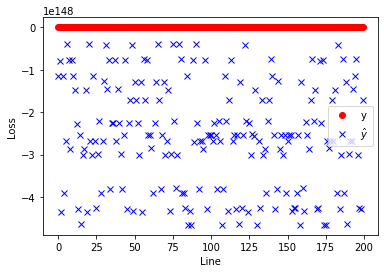

/tmp/ipykernel_5787/2080829935.py:8: RuntimeWarning: overflow encountered in double_scalars
  res += (Y[index] - h(w,line)) * line[i]
/tmp/ipykernel_5787/2080829935.py:8: RuntimeWarning: invalid value encountered in double_scalars
  res += (Y[index] - h(w,line)) * line[i]


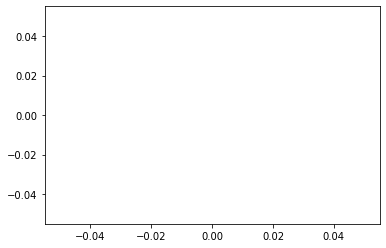

In [37]:
# Code sample that can be used to visualize the difference between the ground truth and the prediction
import matplotlib.pyplot as plt

num_samples_to_plot = 200
plt.plot(Y[0:num_samples_to_plot], 'ro', label='y')
yw = [h(res,x) for x in X]
plt.plot(yw[0:num_samples_to_plot], 'bx', label='$\hat{y}$')
plt.legend()
plt.xlabel("Line")
plt.ylabel("Loss")
plt.show()

w = np.zeros(np.shape(X)[1],dtype=float)
w_list = [descent(w,X,Y,10e-7,i) for i in range(0,500,50)]
emp_loss_list = [emp_loss(elem,X,Y) for elem in w_list]
# index = [i for i in range(0,1000,50)]
plt.plot(emp_loss_list)
plt.show()









# Going further

The following are extensions of the work previously done. If attempting them **do not modify** the code you produced above so that it can be evaluated.

### Improvements to gradient descent

Consider improving the gradient descent with:

 - Stochastic Gradient Descent (SGD), which means selecting a subset of the examples for training
 - Detection of convergence to halt the algorithm before the maximum number of iterations


### Data normalization

Different input features can have different units, and very different ranges.
Within the perceptron computation, these values will be summed together.
While gradient descent is normally able to deal with this (by adapting the weights of the perceptron for each input feature), standardizing the input features usually eases the perceptron training, and can sometimes improve accuracy.




```python
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True) 
X_normalized = sc.fit_transform(X)
```

Try applying a standard normalization to the input features (make sure that you keep a feature column that is always equal to 1). Is the convergence faster ? Try to quantify this speed-up. What about accuracy ?